# BentoML Example: PyTorch Image Classifier

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook was built based on the official pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-cifar10-image-classification&dt=pytorch-cifar10-image-classification)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q bentoml "torch==1.6.0" "torchvision==0.7.0" "pillow==7.2.0"


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

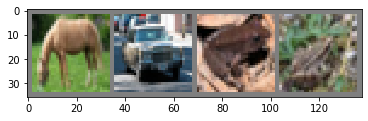

horse   car  frog  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.154
[1,  4000] loss: 1.794
[1,  6000] loss: 1.644
[1,  8000] loss: 1.537
[1, 10000] loss: 1.493
[1, 12000] loss: 1.452
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

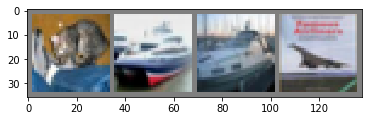

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


# 6 Model Serving with BentoML


First, define ML service with BentoML

In [10]:
%%writefile pytorch_image_classifier.py

from typing import List, BinaryIO

from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms

import bentoml
from bentoml.frameworks.pytorch import PytorchModelArtifact
from bentoml.adapters import FileInput


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@bentoml.env(pip_packages=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('net')])
class PytorchImageClassifier(bentoml.BentoService):
    
    @bentoml.utils.cached_property
    def transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    @bentoml.api(input=FileInput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        input_datas = []
        for fs in file_streams:
            img = Image.open(fs).resize((32, 32))
            input_datas.append(self.transform(img))

        outputs = self.artifacts.net(Variable(torch.stack(input_datas)))
        _, output_classes = outputs.max(dim=1)

        return [classes[output_class] for output_class in output_classes]

Overwriting pytorch_image_classifier.py


Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [11]:
# 1) import the custom BentoService defined above
from pytorch_image_classifier import PytorchImageClassifier

# 2) `pack` it with required artifacts
bento_svc = PytorchImageClassifier()
bento_svc.pack('net', net)

# 3) save your BentoSerivce to file archive
saved_path = bento_svc.save()
print(saved_path)

[2020-09-23 11:53:42,191] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:53:42,232] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-23 11:53:42,233] WARNING - pip package requirement torch already exist
[2020-09-23 11:53:43,731] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
/opt/conda/envs/bentoml-dev-py36/lib/python3.6/site-packages/setuptools/dist.py:458: UserWarning: Normalizing '0.9.0.pre+7.g8af1c8b' to '0.9.0rc0+7.g8af1c8b'
  warnings.warn(tmpl.format(**locals()))
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py
set BentoML-0.9.0rc0+7.g8af1c8b/bentoml/_version.py to '0.9.0.pre+7.g8af1c8b'
[2020-09-23 11:53:44,541] INFO - BentoService bundle 'PytorchImageClassifier:20200923115342_1E23CA' saved to: /home/bentoml/bentoml/repository/PytorchImageClassifier/20200923115342_1E23CA
/home/bentoml/bentoml/repository/PytorchImageClassifier/20200923115342_1E23CA


## REST API Model Serving (for debug only)


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [13]:
!bentoml serve PytorchImageClassifier:latest --enable-microbatch

[2020-09-23 11:54:05,755] INFO - Getting latest version PytorchImageClassifier:20200923115342_1E23CA
[2020-09-23 11:54:05,755] INFO - Starting BentoML API server in development mode..
[2020-09-23 11:54:06,925] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:54:06,940] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 11:54:07,423] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a B

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [ ]:
!bentoml serve PytorchImageClassifier:latest --run-with-ngrok

Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@bird.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [14]:
!bentoml containerize PytorchImageClassifier:latest -t pytorchimageclassifier:latest

[2020-09-23 11:55:06,975] INFO - Getting latest version PytorchImageClassifier:20200923115342_1E23CA
Found Bento: /home/bentoml/bentoml/repository/PytorchImageClassifier/20200923115342_1E23CA
[2020-09-23 11:55:06,994] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:55:07,008] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
Building Docker image pytorchimageclassifier:latest from PytorchImageClassifier:latest 
-Step 1/15 : FROM bentoml/model-server:0.9.0.pre-py36
 ---> 4aac43d10e50
Step 2/15 : ARG EXTRA_PIP_INSTALL_ARGS=
 ---> Using cache
 ---> 790054f5ad85
Step 3/15 : ENV EXTRA_PIP_INSTALL_ARGS $EXTRA_PIP_INSTALL_ARGS
 ---> Using cache
 ---> 85b0a1b40542
Step 4/15

In [15]:
!docker run --rm -p 5000:5000 pytorchimageclassifier --workers 1

[2020-09-23 03:55:41,801] INFO - Starting BentoML API server in production mode..
[2020-09-23 03:55:42 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-23 03:55:42 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-23 03:55:42 +0000] [1] [INFO] Using worker: sync
[2020-09-23 03:55:42 +0000] [12] [INFO] Booting worker with pid: 12
[2020-09-23 03:55:42,080] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deploying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-09-23 03:55:42,115] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 03:55:42,115] WARNING - Saved BentoService Python version mismatch: loading BentoService b

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [18]:
!bentoml run PytorchImageClassifier:latest predict  --input-file=bird.jpg

[2020-09-23 11:57:11,241] INFO - Getting latest version PytorchImageClassifier:20200923115342_1E23CA
[2020-09-23 11:57:11,317] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-23 11:57:11,331] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+7.g8af1c8b
[2020-09-23 11:57:11,814] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-23 11:57:11,814] WARNING - pip package requirement torch alrea

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)